In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns

plt.style.use('ggplot')

from seaborn import distplot
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import string
from imblearn.over_sampling import SMOTE


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
kpop = pd.read_csv('data/kpop_song_features.csv', index_col = 0)
kpop2 = pd.read_csv('data/kpop_song_features2.csv', index_col = 0)
kpop3 = pd.read_csv('data/kpop_song_features3.csv', index_col = 0)

kpop_df = pd.concat([kpop, kpop2, kpop3])
kpop_df = kpop_df[kpop_df.release_date != '0000']

In [3]:
kpop_df['release_date'] = pd.to_datetime(kpop_df['release_date'])
kpop_df['year'] = [i.year for i in kpop_df.release_date]
kpop_df['artist_name'] = [i.lower().replace("'", '') for i in kpop_df.artist_name]

In [4]:
kpop_df.head()

,danceability,energy,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,release_date,year
0,0.714,0.736,2,0.0457,0.1910,0.000000,0.0553,0.814,149.985,210818,4,red velvet,2018-01-29,2018
1,0.721,0.924,7,0.0524,0.1350,0.000000,0.0427,0.801,124.024,229097,4,red velvet,2018-01-29,2018
2,0.839,0.902,1,0.0536,0.0868,0.002570,0.2720,0.639,114.953,189050,4,red velvet,2018-01-29,2018
3,0.761,0.785,7,0.0520,0.0792,0.000112,0.1420,0.780,111.037,245599,4,red velvet,2018-01-29,2018
4,0.686,0.752,7,0.0322,0.5860,0.000002,0.3640,0.906,149.998,188304,4,red velvet,2018-01-29,2018


In [5]:
kpop_df.groupby('artist_name').agg({'speechiness':'mean', 'instrumentalness':'mean', 'danceability':'mean', 'energy':'mean','acousticness':'mean', 'valence':'mean'}).sort_values('speechiness', ascending = False)

,speechiness,instrumentalness,danceability,energy,acousticness,valence
artist_name,,,,,,
bts,0.172844,1.239960e-02,0.601454,0.801566,0.118142,0.547792
bigbang,0.108219,6.586041e-03,0.582627,0.832900,0.109640,0.439794
red velvet,0.094951,1.768199e-02,0.668874,0.748158,0.224725,0.627593
wanna one,0.094881,0.000000e+00,0.616815,0.787222,0.199652,0.551296
ikon,0.093867,2.812817e-02,0.630211,0.796621,0.191380,0.517419
2ne1,0.086835,2.792792e-02,0.655160,0.753032,0.120321,0.498756
exo,0.085738,4.107561e-02,0.628088,0.772642,0.172819,0.546436
shinee,0.083504,1.434579e-02,0.637085,0.807092,0.143948,0.586216
twice,0.082060,2.008758e-02,0.696681,0.827163,0.163619,0.612024


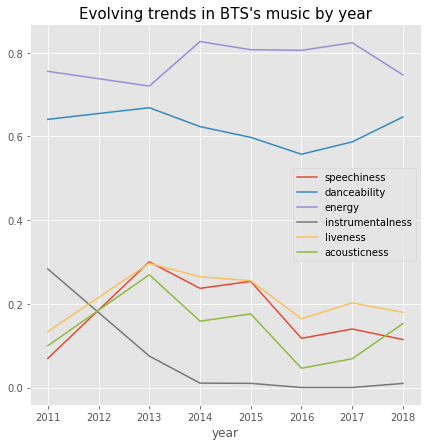

In [6]:
bts_grouped = kpop_df[kpop_df.artist_name == 'bts']

bts_grouped.groupby('year').agg({'speechiness':'mean', 'danceability':'mean', 'energy':'mean', 'instrumentalness':'mean', 'liveness':'mean', 'acousticness':'mean'}).plot(figsize = (7,7));
title('Evolving trends in BTS\'s music by year', size = 15);

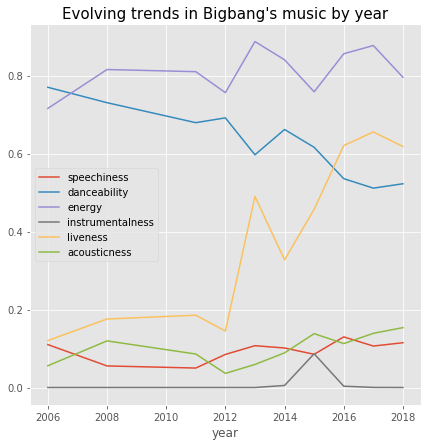

In [7]:
bigbang_grouped = kpop_df[kpop_df.artist_name == 'bigbang']
bigbang_grouped.groupby('year').agg({'speechiness':'mean', 'danceability':'mean', 'energy':'mean', 'instrumentalness':'mean', 'liveness':'mean', 'acousticness':'mean'}).plot(figsize = (7,7));
title('Evolving trends in Bigbang\'s music by year', size = 15);

In [8]:
bts_tempo = kpop_df[kpop_df['artist_name'] == 'bts']['tempo']  
bigbang_tempo = kpop_df[kpop_df['artist_name'] == 'bigbang']['tempo']  

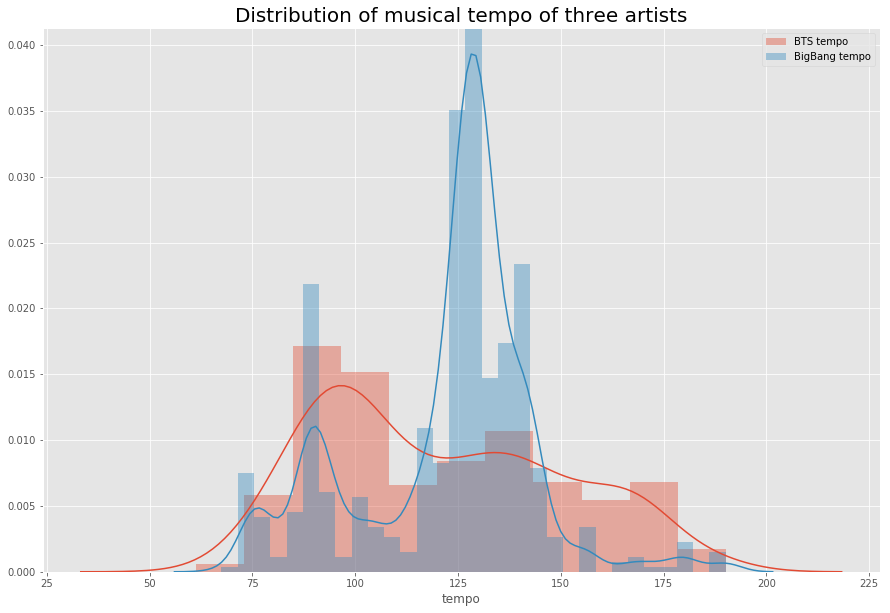

In [9]:
figure = figsize(15,10)
sns.distplot(bts_tempo, label = 'BTS tempo');
sns.distplot(bigbang_tempo, label = 'BigBang tempo');
title('Distribution of musical tempo of three artists', size = 20)
legend();

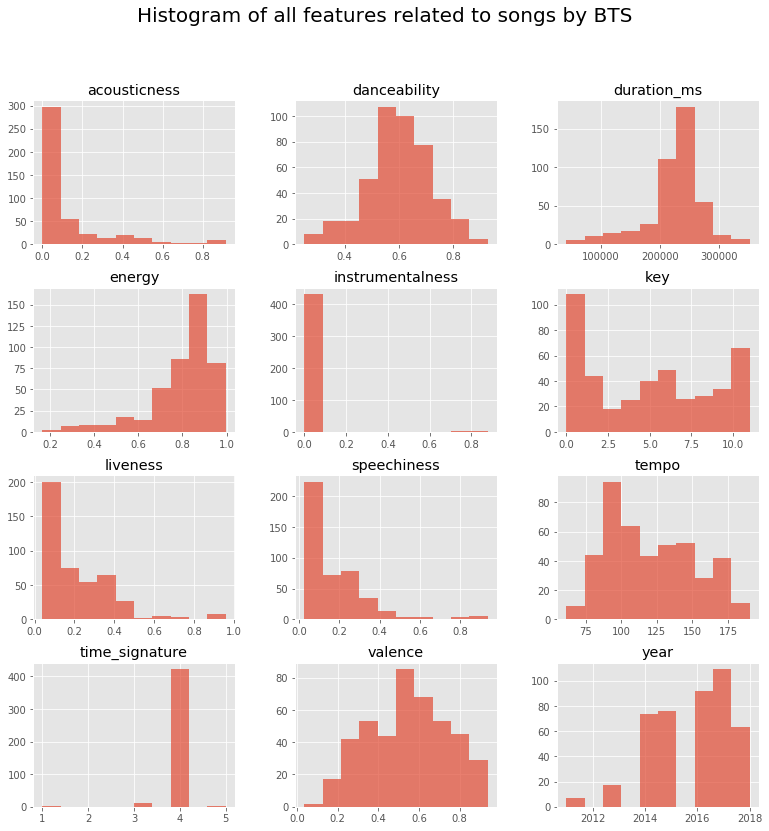

In [10]:
figure = figsize(13,13)
kpop_df[kpop_df.artist_name == 'bts']._get_numeric_data().hist(alpha = 0.7);
suptitle('Histogram of all features related to songs by BTS', size = 20);

# Baseline Modeling for a BTS classifier

In [11]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations


In [12]:
kpop_df_copy = kpop_df.copy()

kpop_df['target'] = [1 if i == 'bts' else 0 for i in kpop_df.artist_name]
kpop_df = kpop_df.drop(['artist_name','release_date','year'], 1)

In [13]:
X_train, X_validation, y_train, y_validation = train_test_split(kpop_df.iloc[:,:-1], kpop_df.target, train_size=0.2)


In [14]:
X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

In [15]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('index')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('index')

In [16]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
model.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.919444	valid_0's binary_logloss: 0.402629
[400]	valid_0's auc: 0.932255	valid_0's binary_logloss: 0.392164
Early stopping, best iteration is:
[316]	valid_0's auc: 0.928149	valid_0's binary_logloss: 0.386873


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [17]:
validation_pred_proba_grad = model.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.9281489934172286

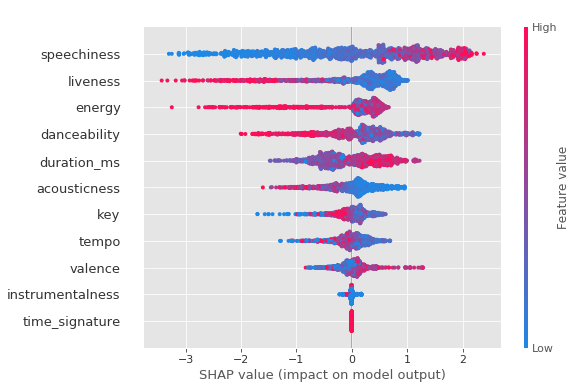

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

In [19]:
model2 = RandomForestClassifier()

model2.fit(X_train_smote,y_train_smote)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
validation_pred_proba_grad = model2.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.9074177057242517

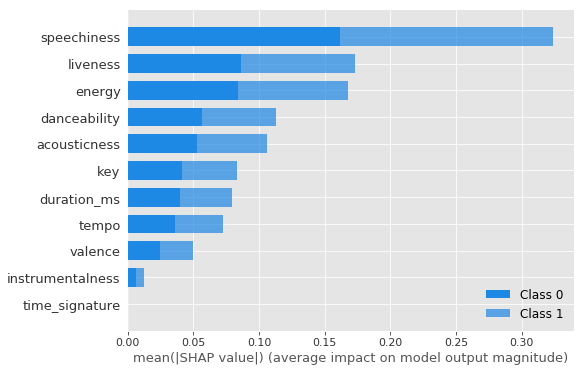

In [21]:
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

# Comparing Korean pop with American Pop

In [11]:
apop = pd.read_csv('data/apop_song_features.csv', index_col = 0)
apop2 = pd.read_csv('data/apop_song_features2.csv', index_col = 0)
apop3 = pd.read_csv('data/apop_song_features3.csv', index_col = 0)

apop_df = pd.concat([apop, apop2, apop3])
apop_df = apop_df[apop_df.release_date != '0000']

apop_df['artist_name'] = [i.lower().replace("'", '') for i in apop_df.artist_name]

In [12]:
apop_df['release_date'] = pd.to_datetime(apop_df['release_date'])
apop_df['year'] = [i.year for i in apop_df.release_date]

In [13]:
kpop_df = kpop_df_copy

kpop_df['target'] = 1
apop_df['target'] = 0

NameError: name 'kpop_df_copy' is not defined

In [ ]:
df = pd.concat([kpop_df, apop_df])

In [ ]:
pd.concat([kpop_df.artist_name.value_counts(), apop_df.artist_name.value_counts()])


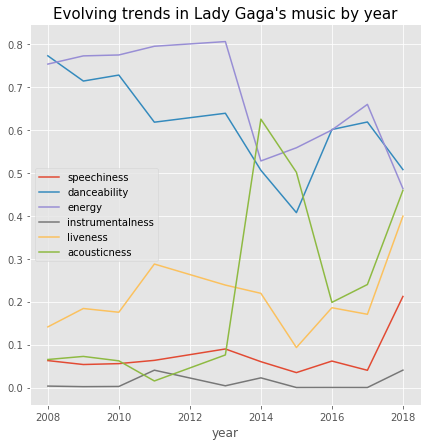

In [14]:
ladygaga_grouped = apop_df[apop_df.artist_name == 'lady gaga']
ladygaga_grouped.groupby('year').agg({'speechiness':'mean', 'danceability':'mean', 'energy':'mean', 'instrumentalness':'mean', 'liveness':'mean', 'acousticness':'mean'}).plot(figsize = (7,7));
title('Evolving trends in Lady Gaga\'s music by year', size = 15);

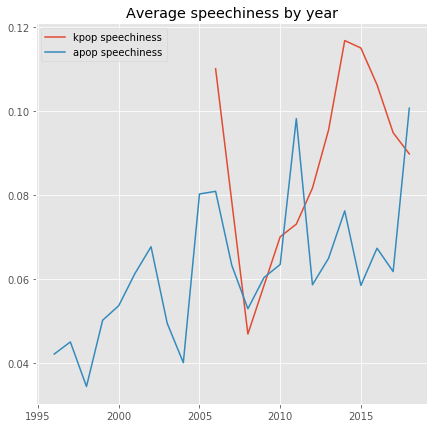

In [28]:
figure = figsize(7,7)
plt.subplot(1, 1, 1)
plot(kpop_df.groupby('year').agg({'speechiness':'mean'}), label = 'kpop speechiness');

plt.subplot(1, 1, 1)
plot(apop_df.groupby('year').agg({'speechiness':'mean'}), label = 'apop speechiness');
title('Average speechiness by year')
legend();

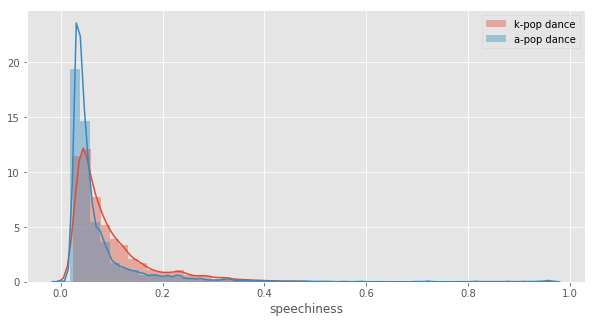

In [29]:
figure = figsize(10,5)
sns.distplot(df[df.target == 1]['speechiness'], label = 'k-pop dance');
sns.distplot(df[df.target == 0]['speechiness'], label = 'a-pop dance');
legend();

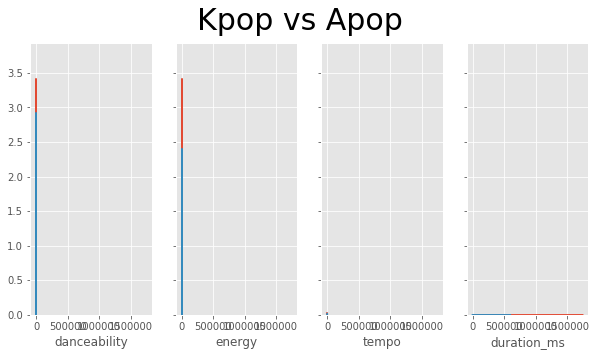

In [30]:
f, axes = subplots(1, 4, figsize=(10, 5), sharex=True, sharey = True)

sns.distplot(df[df.target == 1][df.columns[0]], ax = axes[0]);
sns.distplot(df[df.target == 0][df.columns[0]], ax = axes[0]);

sns.distplot(df[df.target == 1][df.columns[1]], ax = axes[1]);
sns.distplot(df[df.target == 0][df.columns[1]], ax = axes[1]);

sns.distplot(df[df.target == 1][df.columns[8]], ax = axes[2]);
sns.distplot(df[df.target == 0][df.columns[8]], ax = axes[2]);

sns.distplot(df[df.target == 1][df.columns[9]], ax = axes[3]);
sns.distplot(df[df.target == 0][df.columns[9]], ax = axes[3]);

suptitle('Kpop vs Apop', fontsize = 30);

# Modeling with Automated feature engineering to distinguish Kpop from Apop

In [31]:
import featuretools as ft
import featuretools.variable_types as vtypes

es = ft.EntitySet(id = 'passengers')

In [32]:
y = df.target
df = df.drop(['artist_name','release_date','year', 'target'], 1)


In [33]:
df_types = {}

for col in df:
    if (df[col].nunique() == 2) and (df[col].dtype == int or df[col].dtype == float):
        df_types[col] = vtypes.Boolean
    elif (df[col].nunique() != 2) and (df[col].dtype == int or df[col].dtype == float):
        df_types[col] = vtypes.Numeric
        
df_types['key'] = vtypes.Ordinal

In [34]:
df_types

{'danceability': featuretools.variable_types.variable.Numeric,
 'energy': featuretools.variable_types.variable.Numeric,
 'key': featuretools.variable_types.variable.Ordinal,
 'speechiness': featuretools.variable_types.variable.Numeric,
 'acousticness': featuretools.variable_types.variable.Numeric,
 'instrumentalness': featuretools.variable_types.variable.Numeric,
 'liveness': featuretools.variable_types.variable.Numeric,
 'valence': featuretools.variable_types.variable.Numeric,
 'tempo': featuretools.variable_types.variable.Numeric,
 'duration_ms': featuretools.variable_types.variable.Numeric,
 'time_signature': featuretools.variable_types.variable.Numeric}

In [35]:
es = es.entity_from_dataframe(entity_id = 'df', dataframe = df, variable_types = df_types, index = 'indices')

2018-10-10 09:57:03,270 featuretools.entityset - WARNING    index indices not found in dataframe, creating new integer column


In [36]:
es

Entityset: passengers
  Entities:
    df [Rows: 11145, Columns: 12]
  Relationships:
    No relationships

In [37]:
primitives = ft.list_primitives()

print('List of transformation primitives: {}'.format(list(primitives[primitives['type'] == 'transform'].name.values)))

List of transformation primitives: ['percentile', 'month', 'weeks', 'minute', 'cum_max', 'minutes', 'time_since', 'cum_mean', 'seconds', 'subtract', 'years', 'hour', 'diff', 'longitude', 'characters', 'add', 'negate', 'absolute', 'day', 'divide', 'months', 'days_since', 'weekday', 'cum_min', 'week', 'is_null', 'cum_count', 'year', 'numwords', 'multiply', 'weekend', 'haversine', 'not', 'hours', 'cum_sum', 'or', 'second', 'days', 'latitude', 'time_since_previous', 'mod', 'and', 'isin']


In [38]:
agg_primitives = primitives[primitives['type'] == 'aggregation'].name.values
trans_primitives = ['percentile', 'and', 'or','subtract']

feature_names = ft.dfs(entityset = es, target_entity = 'df',
                       trans_primitives = trans_primitives,
                       agg_primitives= agg_primitives, 
                       where_primitives = [], seed_features = [],
                       max_depth = 2, n_jobs = -1, verbose = 1,
                       features_only=True)

Built 401 features


In [39]:
feature_matrix = ft.calculate_feature_matrix(feature_names, 
                                                 entityset=es, 
                                                 n_jobs = 1, 
                                                 verbose = 0,
                                                 chunk_size = es['df'].df.shape[0])

In [40]:
feature_matrix.shape

(11145, 401)

In [41]:
feature_matrix.head()

,danceability,energy,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,PERCENTILE(danceability),PERCENTILE(energy),PERCENTILE(speechiness),PERCENTILE(acousticness),PERCENTILE(instrumentalness),PERCENTILE(liveness),PERCENTILE(valence),PERCENTILE(tempo),PERCENTILE(duration_ms),PERCENTILE(time_signature),tempo - liveness,tempo - duration_ms,liveness - danceability,valence - duration_ms,time_signature - speechiness,speechiness - duration_ms,danceability - valence,acousticness - danceability,liveness - duration_ms,valence - acousticness,time_signature - danceability,speechiness - acousticness,instrumentalness - duration_ms,liveness - acousticness,duration_ms - danceability,valence - speechiness,liveness - energy,acousticness - duration_ms,danceability - speechiness,speechiness - valence,instrumentalness - liveness,acousticness - valence,acousticness - energy,duration_ms - instrumentalness,danceability - tempo,energy - instrumentalness,tempo - danceability,energy - acousticness,speechiness - liveness,...,PERCENTILE(tempo) - PERCENTILE(valence),PERCENTILE(energy) - PERCENTILE(valence),time_signature - PERCENTILE(valence),PERCENTILE(valence) - PERCENTILE(acousticness),PERCENTILE(time_signature) - speechiness,PERCENTILE(energy) - speechiness,PERCENTILE(instrumentalness) - PERCENTILE(energy),PERCENTILE(acousticness) - PERCENTILE(liveness),PERCENTILE(duration_ms) - PERCENTILE(danceability),PERCENTILE(tempo) - PERCENTILE(duration_ms),PERCENTILE(duration_ms) - time_signature,PERCENTILE(instrumentalness) - instrumentalness,PERCENTILE(instrumentalness) - PERCENTILE(speechiness),PERCENTILE(energy) - instrumentalness,PERCENTILE(energy) - PERCENTILE(speechiness),PERCENTILE(acousticness) - valence,PERCENTILE(energy) - time_signature,time_signature - PERCENTILE(duration_ms),PERCENTILE(speechiness) - valence,PERCENTILE(acousticness) - instrumentalness,PERCENTILE(acousticness) - PERCENTILE(speechiness),PERCENTILE(valence) - speechiness,instrumentalness - PERCENTILE(time_signature),PERCENTILE(speechiness) - PERCENTILE(time_signature),time_signature - PERCENTILE(energy),acousticness - PERCENTILE(tempo),PERCENTILE(liveness) - PERCENTILE(valence),PERCENTILE(instrumentalness) - danceability,PERCENTILE(valence) - PERCENTILE(time_signature),PERCENTILE(duration_ms) - valence,energy - PERCENTILE(instrumentalness),PERCENTILE(valence) - PERCENTILE(tempo),tempo - PERCENTILE(speechiness),liveness - PERCENTILE(energy),PERCENTILE(tempo) - energy,PERCENTILE(danceability) - instrumentalness,PERCENTILE(danceability) - PERCENTILE(speechiness),PERCENTILE(tempo) - tempo,PERCENTILE(valence) - acousticness,PERCENTILE(energy) - duration_ms,PERCENTILE(danceability) - PERCENTILE(liveness),speechiness - PERCENTILE(energy),PERCENTILE(valence) - energy,valence - PERCENTILE(energy),PERCENTILE(danceability) - acousticness,PERCENTILE(speechiness) - energy,liveness - PERCENTILE(valence),PERCENTILE(valence) - PERCENTILE(danceability),PERCENTILE(danceability) - PERCENTILE(energy),PERCENTILE(time_signature) - PERCENTILE(duration_ms)
indices,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.714,0.736,2,0.0457,0.1910,0.000000,0.0553,0.814,149.985,210818,4,0.743248,0.441050,0.420458,0.710677,0.302647,0.041857,0.875415,0.863033,0.327322,0.517766,149.9297,-210668.015,-0.6587,-210817.186,3.9543,-210817.9543,-0.100,-0.5230,-210817.9447,0.6230,3.286,-0.1453,-210818.000000,-0.1357,210817.286,0.7683,-0.6807,-210817.8090,0.6683,-0.7683,-0.055300,-0.6230,-0.5450,210818.000000,-149.271,0.736000,149.271,0.5450,-0.0096,...,-0.012382,-0.434365,3.124585,0.164738,0.472066,0.395350,-0.138403,0.668820,-0.415926,0.535711,-3.672678,0.302647,-0.117811,0.441050,0.020592,-0.103323,-3.558950,3.672678,-0.393542,0.710677,0.290220,0.829715,-0.517766,-0.097308,3.558950,-0.672033,-0.833558,-0.411353,0.357649,-0.486678,0.433353,0.012382,149.564542,-0.385750,0.127033,0.743248,0.322790,-149.121967,0.684415,-210817.558

In [97]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations


In [43]:
X_train, X_validation, y_train, y_validation = train_test_split(feature_matrix, y, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

In [49]:
X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('indices')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('indices')


model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
model.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.883979	valid_0's binary_logloss: 0.449699
[400]	valid_0's auc: 0.903836	valid_0's binary_logloss: 0.396577
[600]	valid_0's auc: 0.91146	valid_0's binary_logloss: 0.378531
[800]	valid_0's auc: 0.915736	valid_0's binary_logloss: 0.371155
Early stopping, best iteration is:
[871]	valid_0's auc: 0.916836	valid_0's binary_logloss: 0.369934


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

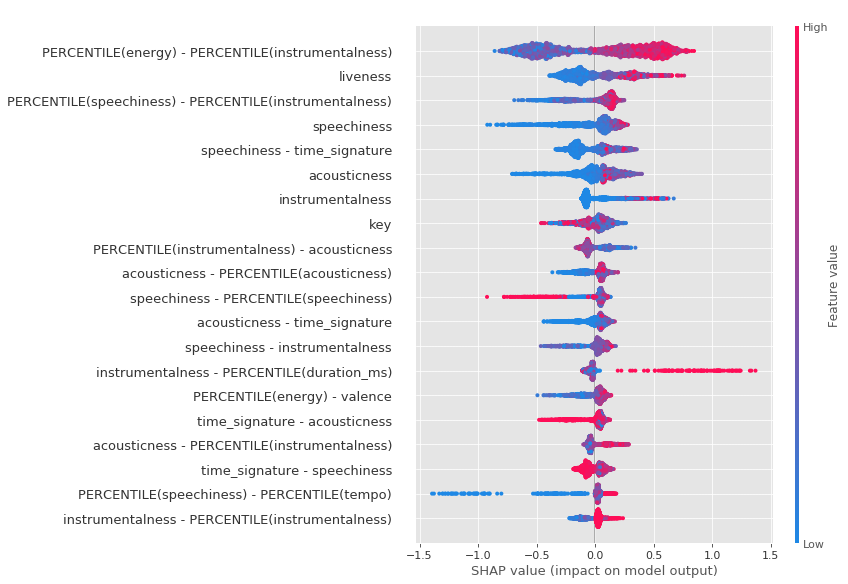

In [50]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

In [67]:
top_features = ['PERCENTILE(energy) - PERCENTILE(instrumentalness)', 'liveness','PERCENTILE(speechiness) - PERCENTILE(instrumentalness)','speechiness','speechiness - time_signature','acousticness','instrumentalness','key','PERCENTILE(instrumentalness) - acousticness','acousticness - PERCENTILE(acousticness)', 'speechiness - PERCENTILE(speechiness)', 'acousticness - time_signature']


In [68]:
filtered_df = feature_matrix[top_features]

In [71]:
X_train, X_validation, y_train, y_validation = train_test_split(filtered_df, y, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

In [72]:
X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('indices')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('indices')


model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
model.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.848813	valid_0's binary_logloss: 0.491598
[400]	valid_0's auc: 0.870124	valid_0's binary_logloss: 0.451097
[600]	valid_0's auc: 0.880648	valid_0's binary_logloss: 0.433294
[800]	valid_0's auc: 0.887344	valid_0's binary_logloss: 0.423497
[1000]	valid_0's auc: 0.891016	valid_0's binary_logloss: 0.419438
[1200]	valid_0's auc: 0.89332	valid_0's binary_logloss: 0.418339
[1400]	valid_0's auc: 0.895038	valid_0's binary_logloss: 0.418403
Early stopping, best iteration is:
[1359]	valid_0's auc: 0.894825	valid_0's binary_logloss: 0.418015


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

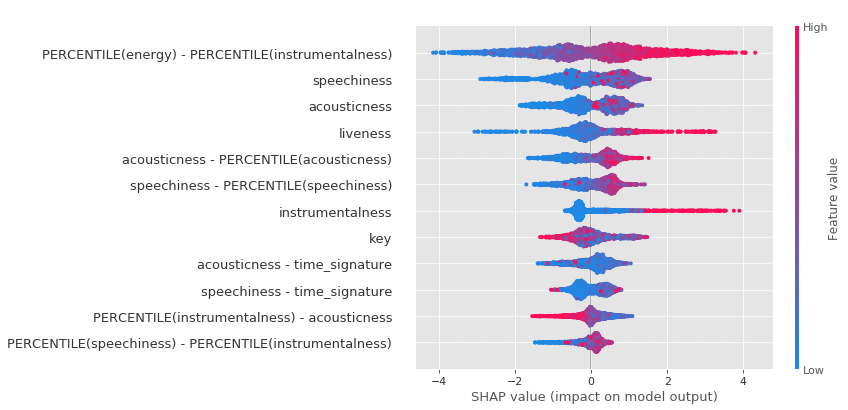

In [73]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

# BTS Lyrics

In [126]:
lyrics = pd.read_csv('data/BTS_translated_lyrics.csv', index_col = 0)

In [127]:
def strip_meta_text(s):
    for i in range(len(s)):
        j = i +1
        try:
            if s[i] == "[":
                while s[j] != "]":
                    j+=1
                s = s.replace(s[i:j +1], '')
            elif s[i] == "(":
                while s[j] != ")":
                    j+=1
                s = s.replace(s[i:j +1], '')
        except Exception as e:
            pass
    return s


In [128]:
lyrics.columns = ['name','text']

In [129]:
lyrics['text'] = lyrics['text'].apply(lambda x: x.lower().replace('\n',' '))

In [130]:
lyrics['text'] = lyrics['text'].apply(lambda x: strip_meta_text(x))

In [141]:
pd.set_option('display.max_colwidth', 0)

In [145]:
lyrics[:5]

,name,text
0,euphoria,"you’re the sun that rose again in my life a reincarnation of my childhood dreams i don’t know what these emotions are am i still dreaming? this dream is a blue mirage in the desert a priori deep inside of me i’m so happy, i can’t breathe my surroundings are getting more and more transparent i hear the far-away ocean across the dream, over the horizon i’m going to the place that’s getting clearer take my hands now you are the cause of my euphoria euphoria take my hands now you are the cause of my euphoria euphoria close the door now when i’m with you i’m in utopia were you wandering around looking for an erased dream too? it’s different from the typical definition of destiny your pained eyes are looking at the same place as me won't you please stay in dreams i hear the ocean from far away across the dream, over the horizon i’m going to the place that’s getting clearer take my hands now you are the cause of my euphoria euphoria take my hands now you are the cause of my euphoria even if the desert becomes cracked no matter who shakes this world don't let go of the hand you're holding please don’t wake up from this dream i hear the ocean from far away across the dream, over the horizon i’m going to the place that’s getting clearer take my hands now you are the cause of my euphoria euphoria take my hands now you are the cause of my euphoria euphoria close the door now when i’m with you i’m in utopia"
1,trivia-just-dance,"if you ask me about that moment bright sunshine was falling down if you ask me about that feeling naturally, it was a one shot into my eyes music playing in those vibes we each stretch getting rid of the nerves if i hid my heart, i would’ve regretted it watching this sunset with you hey, dance with me dance with me any kind of bounce is fine, dance with me where are you from, why are you dancing a natural conversation, say something it’s weird, we’re connecting too much feels like everything will go well but you’re my friend, yeah my friend just i like the feeling of being with you i like the feeling of dancing with you i just wanna, wanna, wanna i really wanna, wanna, wanna just dance to the rhythm of the music however our bodies move we’re shadows underneath the moonlight fall in.. fall in.. i like the feeling of being with you i like the feeling of dancing with you i just wanna, wanna, wanna i really wanna, wanna, wanna just dance in my muddy life you were like a single stem flower even this suffocating studio if we’re together, turns into paradise my dreams that once had no answer now becomes something we can relate to because our rhythm is matching because we have our dance, it’s a fate-like beat let’s get it on pop washing me over with those waves our heartbeats are in sync you’re getting to know my heart too i wanna keep this going i like you like i like to dance so you’re my love, yeah my love that’s what i like i like the feeling of being with you i like the feeling of dancing with you i just wanna, wanna, wanna i really wanna, wanna, wanna just dance to the rhythm of the music however our bodies move we’re shadows underneath the moonlight fall in.. fall in.. i like the feeling of being with you i like the feeling of dancing with you i just wanna, wanna, wanna i really wanna, wanna, wanna just dance i felt it baby this moment, you and me, baby this all fits together like a math formula baby even obscurities, baby even difficulties, baby because of you, i’m comforted from all of that, baby i felt it baby this moment, you and me, baby this all fits together like a math formula baby even rough breathing, baby even shedding sweat, baby because of you, it all has meaning, baby i like the feeling of being with you i like the feeling of dancing with you i just wanna, wanna, wanna i really wanna, wanna, wanna just dance"
2,dimple,"you hide but only appear when you smile where did you come from? don’t lie, i know you’re an angel what are you? but you that smile is so cruel cruel i shouldn’t h

In [147]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
analyzer = SentimentIntensityAnalyzer()

In [148]:
polarity_dic = {}

for sentence in lyrics.text:
    vader_sentiment = analyzer.polarity_scores(sentence).items()
    sent_list = []
    for sentiment in vader_sentiment:
        sent_list.append(sentiment[1])
        
    polarity_dic[sentence] = sent_list

In [161]:
lyrics = lyrics.join(pd.DataFrame(list(polarity_dic.values())).rename(columns = {0:'neg', 1:'neu',2:'pos', 3:'compound'}))

In [167]:
# lyrics.text.to_csv('bts_lyrics.txt', header = None, index = None, sep = ' ', mode = 'a')

### Gensim

In [172]:
import gensim
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

In [168]:

class LabeledLineSentence (object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [180]:
sources = {'bts_lyrics.txt':'bts_lyrics'}

sentences = LabeledLineSentence(sources)

In [186]:
model = Doc2Vec(min_count=1, window=10, size=150, sample=1e-4, negative=5, workers=7)

model.build_vocab(sentences.to_array())

In [187]:
model.train(sentences.sentences_perm(), total_examples=model.corpus_count, epochs= 10)

In [188]:
model.save('doc2vecmodel')

In [189]:
gensim_model = gensim.models.Doc2Vec.load('doc2vecmodel')

In [190]:
gensim_model.most_similar('sing')

[('hair', 0.9998424053192139),
 ('makes', 0.9998419880867004),
 ('white', 0.9998401403427124),
 ('song', 0.9998363852500916),
 ('first', 0.9998318552970886),
 ('uh', 0.9998307228088379),
 ('filled', 0.9998252391815186),
 ('there’s', 0.9998247623443604),
 ('sang', 0.9998242259025574),
 ('world,', 0.9998236894607544)]

# Tfidf Vectorizer

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer(stop_words = 'english')

vectorizer.fit(list(lyrics.text.values))

vectorized = vectorizer.transform(lyrics.text)

# train_vectorized = vectorizer.transform(df['phrase'])
# test_vectorized = vectorizer.transform(test['phrase'])

In [201]:
vectorized

<199x2236 sparse matrix of type '<class 'numpy.float64'>'
	with 17526 stored elements in Compressed Sparse Row format>

In [207]:
feature_names = np.array(vectorizer.get_feature_names())
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['like' 'don' 'just' 'know' 'want' 'll' 'say' 'love' 'time' 'away']

Features with highest idf:
['erode' 'escape' 'smoky' 'smirk' 'euphoria' 'smelled' 'exceptions'
 'slightly' 'sounds' 'learn']


# Use LDA to identify topic

In [210]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

cv = CountVectorizer(stop_words='english')
cv.fit(lyrics['text'])
X = cv.transform(lyrics['text'])
feature_names = cv.get_feature_names()

lda = LatentDirichletAllocation(n_components=10)
lda.fit(X)

results = pd.DataFrame(lda.components_,
                      columns=feature_names)

for topic in range(10):
    print('Topic', topic)
    word_list = results.T[topic].sort_values(ascending=False).index
    print(' '.join(word_list[0:25]), '\n')

/Users/Haebichan/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic 0
love don twisted like testing danger bad just hurt really want wish fucking kidding easy playing feel inside fake friend heart way hate doing mad 

Topic 1
oh jump let hands say throw ju scream everybody world worries don away like dreamers crazy jumpin ll money wrong ve roll ay sky ready 

Topic 2
don dream hey day today converse like say make want right gotta really high dope wanna yes hands night know just big yeah ready life 

Topic 3
ille dangerous gal dimple illegal euphoria oh angel want cause deep girl mistake crime illegirl smile kiss existence yes don cruel wanna time possession gets 

Topic 4
la city ma ll make begin daegu yeah right baby say long come like time ran live know wow hands set bow brother raised want 

Topic 5
girl need know fall just save let love tell hand ll wanna don forever like hurt talking away young cold want feelings hate beautiful sorry 

Topic 6
miss mama like hey rain phone ll wanna best little push face know away winter time heart days flowe

# Tfidf and music data

# Tfidf to classify different groups